# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022'

In [3]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 44.2 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
     |████████████████████████████████| 6.5 MB 43.3 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel

#import alibi
#from alibi.explainers import IntegratedGradients

import logging
tf.get_logger().setLevel(logging.ERROR)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Data

In [6]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('data', 'TEST/task4_test.tsv')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)
dpm.load_test()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [7]:
par_ids = []
texts = []
starts = []
finishes = []

with open (os.path.join('data/dontpatronizeme_categories.tsv')) as f:
  for line in f.readlines()[4:]:
    par_id=int(line.strip().split('\t')[0])
    text=line.split('\t')[2]#.lower()
    start=int(line.split('\t')[5])
    finish=int(line.split('\t')[6])

    par_ids.append(par_id)
    texts.append(text)
    starts.append(start)
    finishes.append(finish)

df_text = pd.DataFrame(list(zip(par_ids, texts, starts, finishes)), columns=['par_id', 'text', 'start', 'finish']).sort_values(['par_id', 'start']).drop_duplicates()
df_text.head()

,par_id,text,start,finish
2381,33,Arshad said that besides learning many new asp...,157,243
1232,34,Fast food employee who fed disabled man become...,0,67
2355,42,Vanessa had feelings of hopelessness in her fi...,0,182
868,77,"In September , Major Nottle set off on foot fr...",15,128
869,77,"In September , Major Nottle set off on foot fr...",28,71


In [8]:
prev_par_id = df_text.iloc[0, 0]
prev_text = df_text.iloc[0, 1]
cursor = 0

par_ids = []
words = []
tags = []

for _, row in df_text.iterrows():
  par_id=row[0]
  text=row[1]#.lower()
  start=row[2]
  finish=row[3]

  # finish the previous paragraph
  if par_id != prev_par_id:
    words_o = prev_text[cursor:].split()
    for w in words_o:
      par_ids.append(prev_par_id)
      words.append(w)
      tags.append('O')

    # update par_id, text, initialize cursor
    prev_par_id = par_id
    prev_text = text
    cursor = 0

  # add non-PCL words
  if cursor < start:
    words_o = text[cursor:start].split()
    for w in words_o:
      par_ids.append(par_id)
      words.append(w)
      tags.append('O')
    cursor = start

  # add PCL words
  if cursor >= start and cursor <= finish:
    words_bi = text[cursor:finish].split()
    for w in words_bi:
      par_ids.append(par_id)
      words.append(w)
      tags.append('I')
    cursor = finish

words_o = prev_text[cursor:].split()
for w in words_o:
  par_ids.append(prev_par_id)
  words.append(w)
  tags.append('O')
        
df_words = pd.DataFrame(list(zip(par_ids, words, tags)), columns=['par_id', 'word', 'tag'])
#print(df_words.loc[40:60])
#df_words.to_csv('df_words.csv')
df_words

,par_id,word,tag
0,33,Arshad,O
1,33,said,O
2,33,that,O
3,33,besides,O
4,33,learning,O
...,...,...,...
53961,10469,A,I
53962,10469,good,I
53963,10469,day,O
53964,10469,.,O


In [9]:
trids = pd.read_csv('practice splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('practice splits/dev_semeval_parids-labels.csv') 
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
print(trids.shape)
print(teids.shape)

(8375, 2)
(2094, 2)


In [10]:
# Rebuild train set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)

# Rebuild test set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

tedf1 = pd.DataFrame(rows)

# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [11]:
df_words_train = df_words[df_words['par_id'].isin([int(par_id) for par_id in trids.par_id])]
df_words_test = df_words[df_words['par_id'].isin([int(par_id) for par_id in teids.par_id])]

# Bert Model

In [12]:
from transformers import BertTokenizer, TFBertModel

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
tokenizer.tokenize('I am 12342 years old.')

['I', 'am', '123', '##42', 'years', 'old', '.']

In [15]:
tokenizer.encode('I am 12342 years old.')

[101, 146, 1821, 13414, 23117, 1201, 1385, 119, 102]

In [16]:
tokenizer.convert_tokens_to_ids(['I', 'am', '123', '##42', 'years', 'old', '.'])

[146, 1821, 13414, 23117, 1201, 1385, 119]

In [17]:
tokenizer.convert_ids_to_tokens([146, 1821, 13414, 23117, 1201, 1385, 119])

['I', 'am', '123', '##42', 'years', 'old', '.']

In [18]:
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.layers
len(bert.layers[0].weights)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


199

In [19]:
input_ids = np.array([tokenizer.encode('I am 12342 years old.')])
bert_output = bert(input_ids)
bert_output[0].shape
bert_output[0]

<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[ 0.36603326,  0.13595207,  0.18560986, ..., -0.15460223,
          0.30067325,  0.02030987],
        [ 0.39042917, -0.33958158,  0.645588  , ..., -0.1969164 ,
          0.1402994 ,  0.262598  ],
        [-0.18811195, -0.06209287,  0.43153697, ...,  0.06182083,
         -0.12960535,  0.2413466 ],
        ...,
        [-0.18485871, -0.26880467,  0.5040917 , ...,  0.05255304,
          0.55420876,  0.24955879],
        [ 0.19845207,  0.09328823,  0.41547233, ..., -0.08608232,
          0.24223724, -0.16197523],
        [ 0.5937221 , -0.01873304,  0.06823751, ..., -0.06672046,
          0.16008165, -0.04144573]]], dtype=float32)>

# Input Generation

In [20]:
def addWord(word, tag):
    """
    Convert a word into a word token and add supplied tags. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, tag label
    returns: dictionary with tokens and labels
    """
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['tagToken'] = [tag] + [tag] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

addWord('10000', 'O')

{'tagToken': ['O', 'O'], 'tokenLength': 2, 'wordToken': ['1000', '##0']}

In [21]:
max_length = 200

In [22]:
def gen_input(df_words, max_length):

  # lists for sentences, tokens, labels, etc.  
  sentenceList = []
  sentenceTokenList = []
  tagTokenList = []
  sentLengthList = []

  # lists for BERT input
  bertSentenceIDs = []
  bertMasks = []
  bertSequenceIDs = []

  sentence = ''

  # always start with [CLS] tokens
  sentenceTokens = ['[CLS]']
  tagTokens = ['[tagCLS]']

  prev_par_id = -1

  for _, row in df_words.iterrows():

    par_id=row[0]
    word=row[1]
    tag=row[2]

    # if new sentence starts
    if par_id != prev_par_id:

      sentenceLength = min(max_length-1, len(sentenceTokens))
      sentLengthList.append(sentenceLength)

      # create space for a least a final '[SEP]' token
      if sentenceLength >= max_length - 1:
        sentenceTokens = sentenceTokens[:max_length-2]
        tagTokens = tagTokens[:max_length-2]

      # add a [SEP] token and padding
      sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length - 1 - len(sentenceTokens))
      tagTokens += ['[tagSEP]'] + ['[tagPAD]'] * (max_length - 1 - len(tagTokens))

      sentenceList.append(sentence)
      sentenceTokenList.append(sentenceTokens)

      bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
      bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length - 1 - sentenceLength))
      bertSequenceIDs.append([0] * (max_length))

      tagTokenList.append(tagTokens)

      sentence = ''
      sentenceTokens = ['[CLS]']
      tagTokens = ['[tagCLS]']
      prev_par_id = par_id

      sentence += ' ' + word

    addDict = addWord(word, tag)

    sentenceTokens += addDict['wordToken']
    tagTokens += addDict['tagToken']

  # the first list elements need to be removed. 
  sentLengthList = sentLengthList[1:]
  sentenceTokenList = sentenceTokenList[1:]
  bertSentenceIDs = bertSentenceIDs[1:]
  bertMasks = bertMasks[1:]
  bertSequenceIDs = bertSequenceIDs[1:]
  tagTokenList = tagTokenList[1:]

  return sentLengthList, sentenceTokenList, bertSentenceIDs, bertMasks, bertSequenceIDs, tagTokenList



In [23]:
# sentLengthList, sentenceTokenList, bertSentenceIDs, bertMasks, bertSequenceIDs, tagTokenList = gen_input(df_words, max_length)
# print(sentenceTokenList[1])
# print(tagTokenList[1])
# print(bertMasks[1])
# print(bertSequenceIDs[1])

# Initial Data Analysis

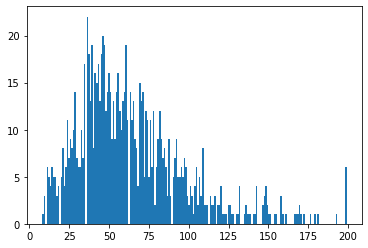

In [ ]:
sentenceLengths= [l for l in sentLengthList]
plt.hist(np.array(sentenceLengths), bins=(max_length-2));

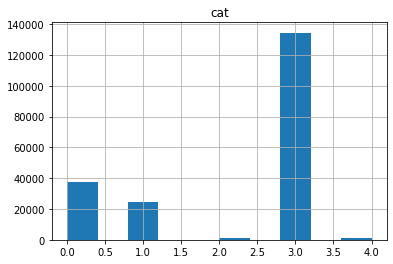

In [ ]:
numSentences = len(bertSentenceIDs)

tagClasses = pd.DataFrame(np.array(tagTokenList).reshape(-1))
tagClasses.columns = ['tag']
tagClasses.tag = pd.Categorical(tagClasses.tag)
tagClasses['cat'] = tagClasses.tag.cat.codes
tagClasses['sym'] = tagClasses.tag.cat.codes
tagLabels = np.array(tagClasses.cat).reshape(numSentences, -1) 

tagClasses[['cat']].hist();

In [ ]:
tagDistribution = (tagClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

tagClasses = tagDistribution.tag.nunique()

tagDistribution.loc[tagDistribution.occurences>0]

,tag,cat,occurences
0,I,0,37507
6,O,1,24511
12,[tagCLS],2,992
18,[tagPAD],3,134398
24,[tagSEP],4,992


# Final Data Prep

In [24]:
#bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [25]:
_, _, trainSentence_ids, trainMasks, trainSequence_ids, tagClasses_train = gen_input(df_words_train, max_length)
_, _, testSentence_ids, testMasks, testSequence_ids, tagClasses_test = gen_input(df_words_test, max_length)

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

In [26]:
l = ['I', 'O', '[tagCLS]', '[tagPAD]', '[tagSEP]']
d = dict([(y,x) for x,y in enumerate(sorted(set(l)))])
print(d)

tagLabels_train = np.array([[d[y] for y in x] for x in tagClasses_train])
tagLabels_test = np.array([[d[y] for y in x] for x in tagClasses_test])

{'I': 0, 'O': 1, '[tagCLS]': 2, '[tagPAD]': 3, '[tagSEP]': 4}


In [27]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    
bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]

labels_train_k = tagLabels_train[k_start:k_end_train]
labels_test_k = tagLabels_test[k_start:k_end_test]

In [28]:
train_all = [bert_inputs_train_k, labels_train_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [29]:
# import pickle

# with open(r"./bert_train_data.pickle", "wb") as output_file:
#     pickle.dump(train_all, output_file)
    
# with open(r"./bert_test_data.pickle", "wb") as output_file:
#     pickle.dump(test_all, output_file)

In [30]:
# with open(r"./bert_train_data.pickle", "rb") as input_file:
#     bert_inputs_train_k, labels_train_k = train_all = pickle.load(input_file)
    
# with open(r"./bert_test_data.pickle", "rb") as input_file:
#     bert_inputs_test_k, labels_test_k = test_all = pickle.load(input_file)

# The Model

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

In [32]:
numTagClasses = 5

def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 2)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numTagClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))

In [33]:
y_true = tf.constant([[2],[0]])
y_pred = tf.constant([[0.2, 0.2, 0.2, 0.2, 0.2], [0.9, 0.1, 0.0, 0.0, 0.0]])
print(custom_loss(y_true, y_pred)) # -np.log(0.9)

tf.Tensor(0.10536089, shape=(), dtype=float32)


In [34]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 2)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numTagClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [35]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

bert_layer = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [37]:
max_input_length = max_length + 1
train_layers = -1
optimizer = adam_customized

in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]

# Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
# the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 

# Freeze layers, i.e. only train number of layers specified, starting from the top
if not train_layers == -1:
    retrain_layers = []
    for retrain_layer_number in range(train_layers):
        layer_code = '_' + str(11 - retrain_layer_number)
        retrain_layers.append(layer_code)
    for w in bert_layer.weights:
        if not any([x in w.name for x in retrain_layers]):
            w._trainable = False
# End of freezing section

bert_sequence = bert_layer(bert_inputs)[0]
dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
dense = tf.keras.layers.Dropout(rate=0.1)(dense)
pred = tf.keras.layers.Dense(5, activation='softmax', name='tag')(dense)

## Prepare for multipe loss functions, although not used here
losses = {"tag": custom_loss,}
lossWeights = {"tag": 1.0}

model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens])

In [39]:
model.fit(
    bert_inputs_train_k, 
    {"tag": labels_train_k },
    validation_data=(bert_inputs_test_k, {"tag": labels_test_k }),
    epochs=3,
    batch_size=16
)

Epoch 1/3
50/50 [==============================] - 23s 453ms/step - loss: 0.3353 - custom_acc_orig_tokens: 0.8661 - val_loss: 0.5876 - val_custom_acc_orig_tokens: 0.7365
Epoch 2/3
50/50 [==============================] - 23s 453ms/step - loss: 0.2218 - custom_acc_orig_tokens: 0.9176 - val_loss: 0.6911 - val_custom_acc_orig_tokens: 0.7371
Epoch 3/3
50/50 [==============================] - 23s 453ms/step - loss: 0.1447 - custom_acc_orig_tokens: 0.9499 - val_loss: 0.8500 - val_custom_acc_orig_tokens: 0.7396


In [41]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]

result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [46]:
print(result.shape)
print(np.argmax(result, axis=2)[8])

(198, 200, 5)
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [51]:
predictions_flat = [pred for preds in np.argmax(result, axis=2) for pred in preds]
labels_flat = [label for labels in tagLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 2:
        clean_preds.append(pred)
        clean_labels.append(label)

cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
)

cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[6461,  803],
       [2461, 2840]], dtype=int32)>